# <span style="color:#F72585">Regresión Lineal en Python</span>

## <span style="color:#4361EE">Introducción</span>

[Basado en Regresión Lineal - Colab](https://colab.research.google.com/github/RFajardoMonzon/MachineLearningCourse/blob/master/Linear_regression_Regresi%C3%B3n_Lineal.ipynb#scrollTo=p5PAhkSzbkRi)

En esta lección hacemos una primera práctica de modelamiento con un subconjunto muy famoso de datos: El California housing dataset.

El propósito del ejercicio es predecir el valor de las casas en California, basados en 8 variables (features) que se cree están asociadas al precio. Son $20.640$ registros.

## <span style="color:#4361EE">Importamos la librerías que usaremos</span>

In [21]:
# Importamos la librería SKLearn, que trae bastantes funcionalidades de Machine
# Learning. Esta librería también incluye algunos datasets muy conocidos como por
# ejemplo el que vamos a utilizar hoy: El California housing dataset.
import sklearn as skl

# Importamos la función que nos carga los datos. OJO! Esta forma de cargar los
# datos no es habitual. Lo hacemos así porque la librería nos proporciona este
# dataset, que suele ser utilizado comunmente para pruebas. Sin embargo, lo
# habitual sería cargar este dataset nosotros mismos.
from sklearn.datasets import fetch_california_housing

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

## <span style="color:#4361EE">Lectura y documentación de los datos</span>

In [22]:
# Los datos cargados desde la librería Sklearn contienen una descripción del
# dataset que estamos cargando, almacenado en el atributo DESCR.

california_dataset = fetch_california_housing()

print(california_dataset.DESCR)

X = california_dataset.data
Y = california_dataset.target

# Guardamos información de las dimensiones de nuestro dataset. Recuerda: 
# n = número de ejemplos que tenemos de nuestros datos y
# p = número de características que tenemos de cada datos.
# ar = promedio de habitaciones por hogar

n, p = X.shape
ar = X[:, 2] #rm

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

## <span style="color:#4361EE">Análisis exploratorio inicial</span> 

Hoy nos centraremos en modelar la relación existente entre las variables **AveRoom** (promedio de habitaciones por hogar) y **MEDV** (Valor medio de la vivienda). 

Vamos a primero comenzar entendiendo la naturaleza de nuestros datos, realizando un análisis exploratorio preliminar. Recuerde, aquí hacemos uso de las herramientas estadísticas y matemáticas aprendidas para obtener una mejor imagen de lo que los datos representan. 

- **¿Qué preguntas se quieren responder con estas herramientas?**

---


1.  **¿Existe alguna relación entre la variable RM y MEDV?** Demostrar la existencia de dicha relación desde dos vertientes diferentes: grafica un *scatter plot* con cada variable en un eje que te permita visualizar algún patrón identificable. También, utilizar una medida estadística como la correlación entre dos variables r para comprobar cuantitativamente dicha relación. ¿Son coherentes ambos análisis?¿Es coherente con lo que se puede esperar de manera intuitiva?

2.   **¿Cúal es el precio medio de las viviendas cuyo número medio de habitaciones oscila entre 5 y 6?** Aquí nos podemos apoyar en la función ***np.logical_and()*** que sirve para combinar dos condiciones diferentes.

3. **¿Se identifica algún fenómeno anómalo en la distribución de los datos?** Realizar un histograma para la variable MEDV. Aquí se recomienda utilizar un valor elevado de *bins*, por encima de 100, para remarcar el efecto de la anomalía. ¿De qué se trata?¿Cree que se trata de mediciones reales o es fruto de un preprocesamiento previo de los datos?



```{admonition} Consejo
:class: tip
Cuando al hacer un *scatter plot* haya una gran acumulación de puntos en una zona de la gráfica que no te permita identificar la densidad de puntos que hay, es una buena idea añadir algo de transparencia al color de dichos puntos. Esto se consigue con el atributo ***alpha*** de la función ***plot()***.
```

Aquí van los primeros códigos.

In [23]:

def relation_rm_medv(ar, means):
  plt.scatter(ar, means, alpha=0.25)
  plt.title("RM contra MEDV")
  plt.show()
  return np.corrcoef(ar, means)[0, 1]   #  se recibe uma matriz de correlaciones. Se extrae la correlación
  
def price_mean(rm, means):
  filtered_means = means[np.logical_and(rm > 5, rm < 6)]
  return np.mean(filtered_means) * 1000

def medv_hist(medv):
  plt.hist(medv, bins=500)
  plt.show()



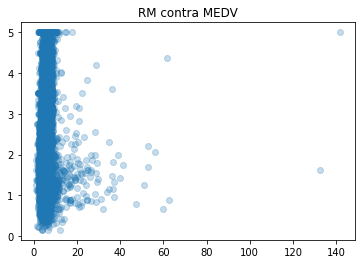

La correlación de RM y MEDV es: 0.15194828974145785
La media de las viviendas con un número de viviendas entre 5 y 6 es: 1901.9380564553448


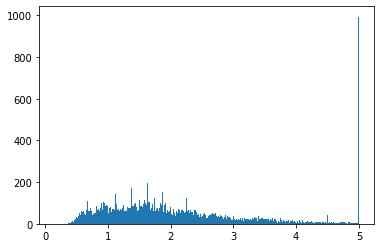

In [24]:
print("La correlación de RM y MEDV es:", relation_rm_medv(ar, Y))
print("La media de las viviendas con un número de viviendas entre 5 y 6 es:", price_mean(ar, Y))
medv_hist(Y)

## <span style="color:#4361EE">Regresión Lineal Simple. Mínimos Cuadrados</span> 

Una vez hemos efectuado el análisis exploratorio inicial, vamos a proceder a implementar y entrenar a nuestro modelo. Recuerde que podemos conseguir ajustar a los datos a una recta de regresión lineal haciendo uso de aquellos valores de los parámetros obtenidos mediante el método de ***Mínimos Cuadrados Ordinarios***. Este método encuentra que el mínimo de la función del ***Error Cuadrático Medio*** se encuentra en el punto donde su derivada es igual a 0. Esto se obtiene evaluando la siguiente expresión:

$$
w = (X^TX)^{-1}X^TY
$$

Para poder trabajar de forma vectorizada, ampliamos la matriz $X$ con una primera columna de valores asignados a $1$, que servirán para mantener al termino independiente.

---

**Lo que vamos a hacer:** 

1.  Ajustar un modelo de regresión lineal mediante el método de ***Mínimos Cuadrados Ordinarios***.
2.  Una vez calculados los parámetros, visualizamos la recta obtenida para comprobar que realmente se ajusta a la nube de puntos.
3.  ¿Qué representa $w_0$?¿Y $w_1$?
4.  Utilizaremos el modelo entrenado para predecir cuál será el valor medio de la vivienda para un número medio de ***9 habitaciones***, y también el número de habitaciones medio que podría tener una vivienda cuyo valor medio es de **45.000**.
5.   Utilizaremos el modelo entrenado para calcular, para cada valor de $X$, cual es el valor predicho por la regresión. Llamaremos al vector generado el vector de salida predicho $\tilde{Y}$. 
6. Luego vamos a evaluar la calidad de las predicciones implementando una función a la que le pasemos como parámetros el vector de valores de salida reales $Y$ y el vector de salida predicho $\tilde{Y}$, para calcular el ***Error Cuadrático Medio***. Recuerda que  el ***ECM*** se calcula como:

$$
\operatorname{ECM}=\frac{1}{n}\sum_{i=1}^n(Y_{Pi} - Y_i)^2. 
$$

```{admonition} Nota
:class: 
Vamos a utilizar el operador @ como un operador equivalente a la función **np.matmul()**, utilizada para la multiplicación matricial. ej : A = B @ C. Realmente, el operador @ implementa de manera general el producto tensorial en Python.

```

```{admonition} Consejo
:class: tip
Al trabajar con multiplicación de matrices y vectores, compruebe que los vectores tengan bien definidas sus dos dimensiones. Esto se puede ver usando con el atributo *X.shape* de dicho vector. Queremos que sus dimensiones se muestren así **(5, 1)** y no así **(5,)**.
Esto se puede producir por ejemplo cuando seleccionamos una única columna de una matriz. En estos casos se puede evitar seleccionando dicha columna así **X[:, 3:4]** en vez de así **X[:, 3]**. Igualmente, en caso de haber perdido una de las dimensiones, las funciones **np.newaxis()** o **reshape()** le pueden ser de ayuda.

ej: `Y = Y[:, np.newaxis]`

```

```{admonition} Info
:class: tip
En el punto 5 calcularemos el error del modelo utilizando todos los datos. Más adelante en el diplomado veremos que esto no es del todo correcto a la hora de evaluar un modelo, pero de momento es suficiente.

```

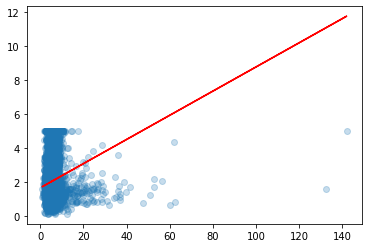

w =  [1.68381151 0.07086879]
Predicción precio con 9 cuartos: $ 2321.63
Predicción del número de cuartos para un precio de $45.000:  611.22
ECM:  1.3


In [25]:
def lineal_regression(x, means):
#   W = (Xt*X)^-1 * Xt*Y 
  w = np.linalg.inv(x.T @ x) @ x.T @ Y
  plt.scatter(ar, means, alpha=0.25)
  plt.plot(ar, x @ w, color="red")
  plt.show()
  return w, x @ w
  
def predict_from_room_number(room_number, w):
  return (w[0] + w[1] * room_number) * 1000
  
def predict_from_price(price, w):
  return (price/1000 - w[0]) / w[1]
  
def get_mse(yp, y):
  return np.mean(np.square(np.subtract(yp, y)))
    

w, yp = lineal_regression(np.c_[np.ones(ar.shape[0]), ar], Y) # np._c concatena a lo largo del segundo eje
print('w = ', w)
print('Predicción precio con 9 cuartos: $',np.round(predict_from_room_number(9, w),2))
print('Predicción del número de cuartos para un precio de $45.000: ', np.round(predict_from_price(45000, w),2))
print('ECM: ',np.round(get_mse(yp, Y),2))
 


## <span style="color:#4361EE">Regresión Lineal Simple. Librería Sklearn</span>  


Hasta este punto hemos usado los conceptos teóricos y prácticos de como funciona el modelo de regresión lineal simple y como se implementa internamente. Esto está muy bien para tener un mejor conocimiento de los conceptos. Sin embargo, en el día a día tenemos que ser efectivos, y para eso lo habitual será utilizar librerías que ya implementen tales modelos. 

Por ejemplo, la librería **Sklearn** ya implementa muchos de los modelos de Machine Learning el modelo de regresión lineal. 

---
Usaremos a continuación la función *sklearn.linear_model.LinearRegression()* para entrenar un modelo de regresión lineal simple con las mismas variables que hemos utilizado en el ejercicio anterior. 

Por favor revise la documentación (online o usando el comando "?") para estudiar los diferentes parámetros que acepta este modelo. 

Por ejemplo ¿Para qué sirve el parámetro *fit_intercept*? 

Se puede entrenar el modelo con y sin dicho parámetro y visualizarlo en una gráfica.

Una vez ajustado el modelo, comprobaremos que el valor de los parámetros obtenidos (también llamados coeficientes) es el mismo que se  obtuvo anteriormente. De la misma forma, utiliza la función *.predict()*, que ya viene implementada, para comprobar que las predicciones son las mismas de antes. 

Finalmente, se comprueba que el valor del Error Cuadrático Medio que se ha obtenido previamente es igual al que proporciona la función ya implementada *sklearn.metrics.mean_squared_error()*. 

Veamos.

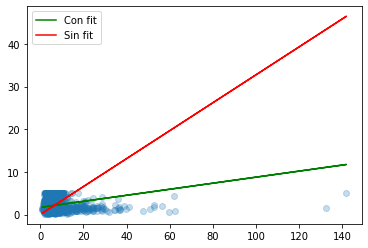

Modelo con fit_intercept: w1 = 0.07086879328040563 w0 = 1.683811508640482 mse = 1.3008070902505424
Modelo sin fit_intercept: w1 = 0.3276841266679844 w0 = 0.0 mse = 1.7883734532122149


In [26]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

#rm.reshape(-1, 1) cambia las dimensiones de rm, de tal manera que la segunda dimensión es 1. 
# el -1 indica a Python que recalcule la primera dimensión.
# En resumen, tranforma el vector rm en una matriz de tamaño n*1.
def use_sklearn():
  model = linear_model.LinearRegression().fit(ar.reshape(-1, 1), Y)
  model_2 = linear_model.LinearRegression(fit_intercept=False).fit(ar.reshape(-1, 1), Y)

  yp = model.predict(ar.reshape(-1, 1))
  yp2 =  model_2.predict(ar.reshape(-1, 1))

  plt.plot(ar, yp, color="green",label="Con fit")
  plt.plot(ar, yp2, color="red",label="Sin fit")
  plt.scatter(ar, Y, alpha=0.25)
  plt.legend()
  plt.show()
  
  fit_intercept_error = mean_squared_error(Y, yp)

  print("Modelo con fit_intercept: w1 =", model.coef_[0], "w0 =",
        model.intercept_, "mse =", fit_intercept_error)
  print("Modelo sin fit_intercept: w1 =", model_2.coef_[0], "w0 =",
        model_2.intercept_, "mse =", mean_squared_error(Y, yp2))
  
use_sklearn()


## <span style="color:#4361EE">Regresión Lineal Múltiple</span>  

Por último, como ya hemos visto, podemos generalizar el modelo de regresión lineal simple añadiendo más variables y obteniendo así el modelo de regresión lineal múltiple. Al añadir más variables al modelo, le estamos dotando de más información que ayude a mejorar las predicciones. Por ejemplo, un modelo de regresión lineal simple podría intentar predecir la altura de una persona en base al tamaño de la mano. Pero si añadieramos otra variable, como por ejemplo, el género, podríamos tener más información para hacer predicciones más fidedignas.

La buena noticia es que a nivel de código, no hay gran diferencia entre ambos modelos, que también pueden ser resueltos mediante el método de ***Mínimos Cuadrados Ordinarios*** evaluando la expresión que ya conocemos:

$$
W = (X^TX)^{-1}X^TY
$$


Veamos.

In [27]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


def user_weights(x):
  return np.linalg.inv(x.T @ x) @ x.T @ Y

x = np.c_[np.ones(ar.shape[0]), ar, X[:, [-1, -3]]]
w = user_weights(x)
print('Coeficientes "a mano":', w) # El primero es el valor resultante cuando el resto de variables son 0, el resto es la importancia (peso) de cada variable.

# Quitamos la columna de unos

x = x[:, 1:]
model = linear_model.LinearRegression().fit(x, Y)
print("Coeficientes sklearn:", model.intercept_, model.coef_)

print("Error regresión lineal múltiple:", mean_squared_error(Y, model.predict(x)))
print("Error regresión lineal simple:", get_mse(yp, Y))



Coeficientes "a mano": [-1.18108628  0.07028057 -0.02405212 -0.00254465]
Coeficientes sklearn: -1.1810862804041613 [ 0.07028057 -0.02405212 -0.00254465]
Error regresión lineal múltiple: 1.2977823651409819
Error regresión lineal simple: 1.3008070902505422
